#  Классификации погодных условий по наличию дождя на следующий день (признак RainTomorrow)

## Модуль A. Загрузка, подготовка и предварительное изучение данных

### Подключение необходимых библиотек

В Google colab изначально установлены все необходимые библиотеки, кроме ppscore.
Установим её:

In [ ]:
!pip install ppscore

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import ppscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import random
random.seed(7)
np.random.seed(7)

TINY_FONT_SIZE = 10
SMALL_FONT_SIZE = 12
MEDIUM_FONT_SIZE = 14
BIGGER_FONT_SIZE = 18
HUGE_FONT_SIZE = 24

plt.rc('font', size=TINY_FONT_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=HUGE_FONT_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_FONT_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_FONT_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_FONT_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_FONT_SIZE)  # fontsize of the figure title

### Работа с данными

#### 1.1 ЗАГРУЗКА ДАННЫХ

In [ ]:
df = pd.read_csv('data/weather.csv')
df

Date Location  MinTemp  ...  Temp3pm  RainToday  RainTomorrow
0       2008-12-01   Albury     13.4  ...     21.8         No            No
1       2008-12-02   Albury      7.4  ...     24.3         No            No
2       2008-12-03   Albury     12.9  ...     23.2         No            No
3       2008-12-04   Albury      9.2  ...     26.5         No            No
4       2008-12-05   Albury     17.5  ...     29.7         No            No
...            ...      ...      ...  ...      ...        ...           ...
128482  2013-10-09  Walpole     10.9  ...     14.8         No            No
128483  2013-10-10  Walpole      9.4  ...     18.5         No            No
128484  2013-10-11  Walpole     13.6  ...     13.5         No           Yes
128485  2013-10-12  Walpole      8.2  ...     13.7        Yes            No
128486  2013-10-13  Walpole      4.9  ...      NaN        NaN           NaN

[128487 rows x 23 columns]

#### 1.2 ПРЕДОБРАБОТКА ДАННЫХ

In [ ]:
# Преобразуем дату в datetime и исходя из неё добавим
# в dataframe две колонки с месяцем и временем года
df['Date'] = pd.to_datetime(df['Date'])
df['month'] = df['Date'].dt.month
# 1 = spring, 2 = summer, 3 = autumn, 4 = winter
df['seasons'] = 4
df.loc[np.logical_and(np.array(3 <= df['month']), np.array(df['month'] <= 5)), 'seasons'] = 1
df.loc[np.logical_and(np.array(6 <= df['month']), np.array(df['month'] <= 8)), 'seasons'] = 2
df.loc[np.logical_and(np.array(9 <= df['month']), np.array(df['month'] <= 11)), 'seasons'] = 3

In [ ]:
df

Date Location  MinTemp  ...  RainTomorrow  month  seasons
0      2008-12-01   Albury     13.4  ...            No     12        4
1      2008-12-02   Albury      7.4  ...            No     12        4
2      2008-12-03   Albury     12.9  ...            No     12        4
3      2008-12-04   Albury      9.2  ...            No     12        4
4      2008-12-05   Albury     17.5  ...            No     12        4
...           ...      ...      ...  ...           ...    ...      ...
128482 2013-10-09  Walpole     10.9  ...            No     10        3
128483 2013-10-10  Walpole      9.4  ...            No     10        3
128484 2013-10-11  Walpole     13.6  ...           Yes     10        3
128485 2013-10-12  Walpole      8.2  ...            No     10        3
128486 2013-10-13  Walpole      4.9  ...           NaN     10        3

[128487 rows x 25 columns]

Посмотрим на пропущенные значения

In [ ]:
total = df.isnull().sum().sort_values(ascending=False)
percent_na = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
data_na = pd.concat([total, percent_na], axis=1, keys=['Total', 'Percent'])
data_na[data_na['Total'] > 0]

Total   Percent
Sunshine       61750  0.480593
Evaporation    56593  0.440457
Cloud3pm       52292  0.406983
Cloud9am       49453  0.384887
Pressure9am    13898  0.108167
Pressure3pm    13860  0.107871
WindGustDir    10041  0.078148
WindGustSpeed   9983  0.077697
WindDir9am      9583  0.074583
WindDir3pm      4076  0.031723
Humidity3pm     3637  0.028306
RainTomorrow    3127  0.024337
RainToday       3125  0.024322
Rainfall        3124  0.024314
WindSpeed3pm    3009  0.023419
Temp3pm         2865  0.022298
Humidity9am     2538  0.019753
WindSpeed9am    1721  0.013394
Temp9am         1703  0.013254
MinTemp         1391  0.010826
MaxTemp         1196  0.009308

Так как в будущем мы будем строить модель классификатора с учителем, то данные без целевых меток (т.е. те данные, где значение RainTomorrow неизвестно) нам не нужны и их можно смело удалить

In [ ]:
df.drop(df[df['RainTomorrow'].isna()].index, axis=0, inplace=True)

Для каждого вида признаков заполнение пропущенных значений происходит по-разному, выделим эти виды

In [ ]:
int_feat = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'month', 'seasons']

cat_feat = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']

bool_feat = ['RainToday', 'RainTomorrow']

Заполним пропущенные значения для целочисленных признаков, путём заполнения средним значением

In [ ]:
df[int_feat] = df[int_feat].fillna(df[int_feat].mean())

In [ ]:
# Посмотрим теперь на пропущенные значения
total = df.isnull().sum().sort_values(ascending=False)
percent_na = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
data_na = pd.concat([total, percent_na], axis=1, keys=['Total', 'Percent'])
data_na[data_na['Total'] > 0]

Total   Percent
WindGustDir   9106  0.072639
WindDir9am    9049  0.072184
WindDir3pm    3635  0.028996
RainToday     1317  0.010506

Теперь заполним пропущенные значения для категориальных признаков, путём заполнения популярнейшим значением

In [ ]:
df['Location'] = df['Location'].fillna(df['Location'].mode()[0])
df['WindGustDir'] = df['WindGustDir'].fillna(df['WindGustDir'].mode()[0])
df['WindDir9am'] = df['WindDir9am'].fillna(df['WindDir9am'].mode()[0])
df['WindDir3pm'] = df['WindDir3pm'].fillna(df['WindDir3pm'].mode()[0])

Осталось заполнить бинарный признак RainToday самым популярным значением

In [ ]:
df['RainToday'] = df['RainToday'].fillna(df['RainToday'].mode()[0])

Не забудем преобразовать бинарные признаки к типу bool

In [ ]:
df[bool_feat] = df[bool_feat].replace(['No'], False)
df[bool_feat] = df[bool_feat].replace(['Yes'], True)

In [ ]:
# Убедимся, что в датасете нет дубликатов и пропущенных значений
print(df.isnull().any())
print()
print(df.duplicated().any())

Date             False
Location         False
MinTemp          False
MaxTemp          False
Rainfall         False
Evaporation      False
Sunshine         False
WindGustDir      False
WindGustSpeed    False
WindDir9am       False
WindDir3pm       False
WindSpeed9am     False
WindSpeed3pm     False
Humidity9am      False
Humidity3pm      False
Pressure9am      False
Pressure3pm      False
Cloud9am         False
Cloud3pm         False
Temp9am          False
Temp3pm          False
RainToday        False
RainTomorrow     False
month            False
seasons          False
dtype: bool

False


In [ ]:
total = df.isnull().sum().sort_values(ascending=False)
percent_na = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
data_na = pd.concat([total, percent_na], axis=1, keys=['Total', 'Percent'])
data_na[data_na['Total'] > 0]

Empty DataFrame
Columns: [Total, Percent]
Index: []

### 1.3 ПРЕДВАРИТЕЛЬНОЕ ИЗУЧЕНИЕ

Посмотрим на максимальное, минимальное значение, среднеквадратичное отклонение, среднее, квартили.

In [ ]:
df.describe()

MinTemp        MaxTemp  ...          month        seasons
count  125360.000000  125360.000000  ...  125360.000000  125360.000000
mean       11.941238      22.880300  ...       6.395756       2.461870
std         6.146498       6.847596  ...       3.425585       1.120895
min        -8.500000      -4.800000  ...       1.000000       1.000000
25%         7.600000      17.900000  ...       3.000000       1.000000
50%        11.900000      22.400000  ...       6.000000       2.000000
75%        16.500000      27.600000  ...       9.000000       3.000000
max        33.900000      48.100000  ...      12.000000       4.000000

[8 rows x 18 columns]

Теперь посмотрим на попарные диаграммы рассеяния признаков, их
распределения и „ящики с усами”.

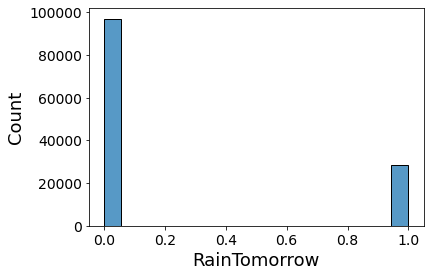

In [ ]:
sns.histplot(df['RainTomorrow'].astype(int));

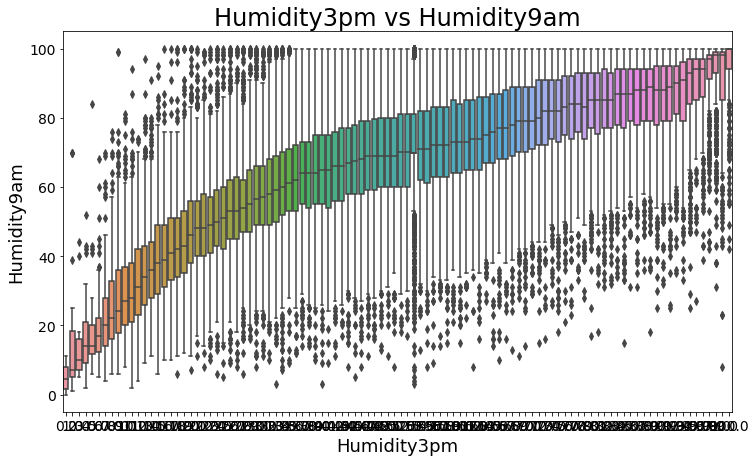

In [ ]:
plt.subplots(figsize=(12, 7))
sns.boxplot(x=df['Humidity3pm'], y=df['Humidity9am'])
plt.title('Humidity3pm vs Humidity9am');

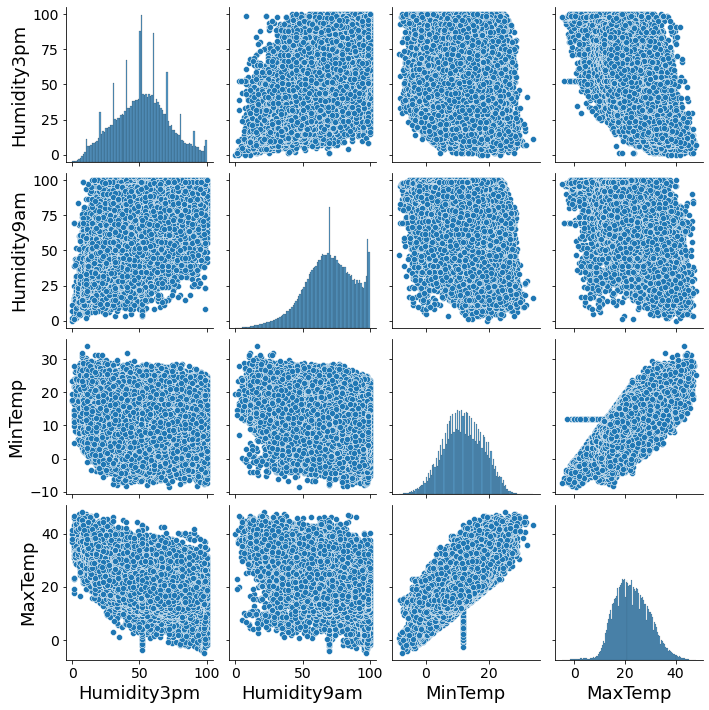

In [ ]:
sns.pairplot(df[['Humidity3pm', 'Humidity9am', 'MinTemp' ,'MaxTemp']]);

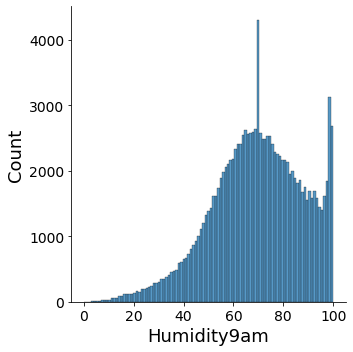

In [ ]:
sns.displot(df['Humidity9am']);

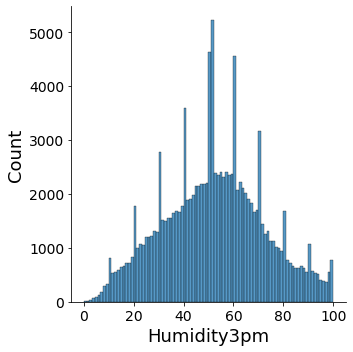

In [ ]:
sns.displot(df['Humidity3pm']);

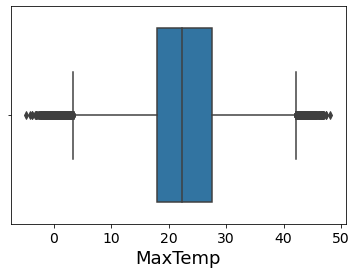

In [ ]:
sns.boxplot(x=df['MaxTemp']);

In [ ]:
sns.boxplot(x=df['MinTemp']);

## Модуль B. Выделение целевой переменной. Изучение параметров, влияющих на целевую переменную. Построение модели.

## Подключение необходимых библиотек и определение вспомогательных функций

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

plt.rc('xtick', labelsize=SMALL_FONT_SIZE)
plt.rc('ytick', labelsize=SMALL_FONT_SIZE)

def create_model_and_print_metrics(classifier, X_train, X_test, y_train, y_test):
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))
  return classifier


## Работа с данными и моделями

### 2.1 ОТБОР ПРИЗНАКОВ

Исходя из чистой логики, можно предположить, что на признак `RainTomorrow` больше всего влияют признаки `Rainfall`, `Sunshine`, `WindGustSpeed`, `Humidity9am`, `Humidity3pm`, `Pressure9am`, `Pressure3pm`, `Cloud9am`, `Cloud3pm` и `RainToday`.

Проверим это предположение в следующем разделе.

### 2.2 ВИЗУАЛЬНОЕ ОБОСНОВАНИЕ ВЫБОРА ПЕРЕМЕННЫХ

In [ ]:
# Для удобства целевой признак поставим в конец столбцов
cols = [col for col in df if col != 'RainTomorrow'] + ['RainTomorrow']
df = df[cols]

Для начала посмотрим на матрицу корреляции признаков между собой.

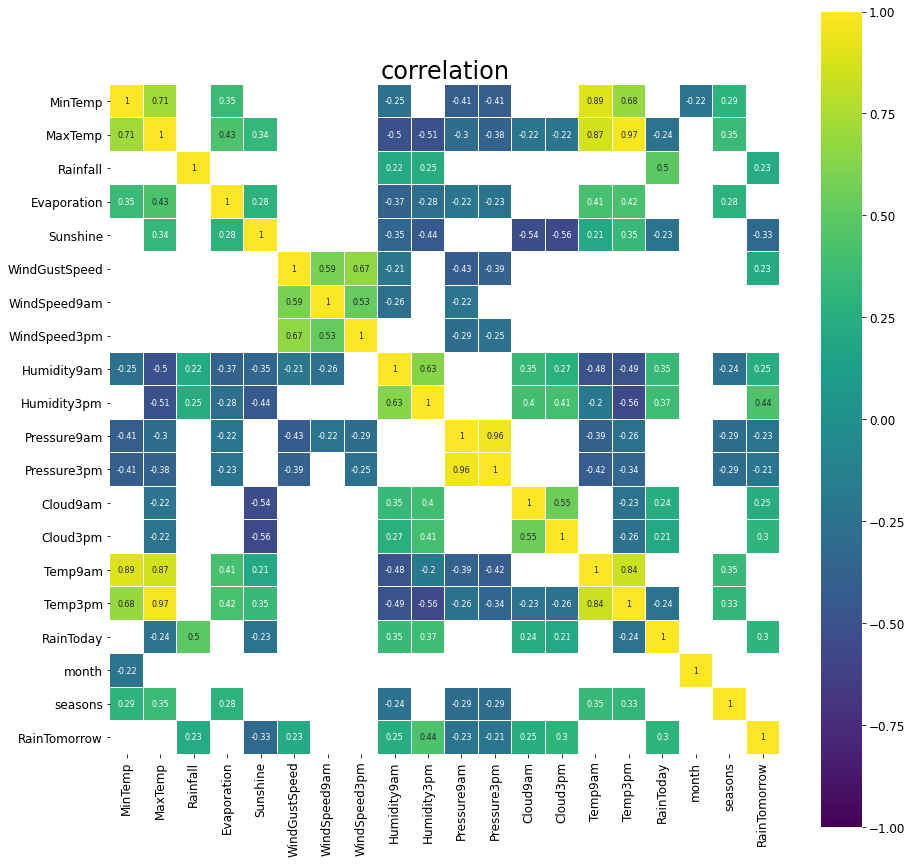

In [ ]:
corr = df.corr()
plt.figure(figsize=(15, 15))

sns.heatmap(corr[(corr > 0.2) | (corr < -0.2)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.05,
            annot=True, annot_kws={"size": 8}, square=True);
plt.title("correlation");

Особенно внимательно посмотрим на корреляцию признаков с целевой переменной.

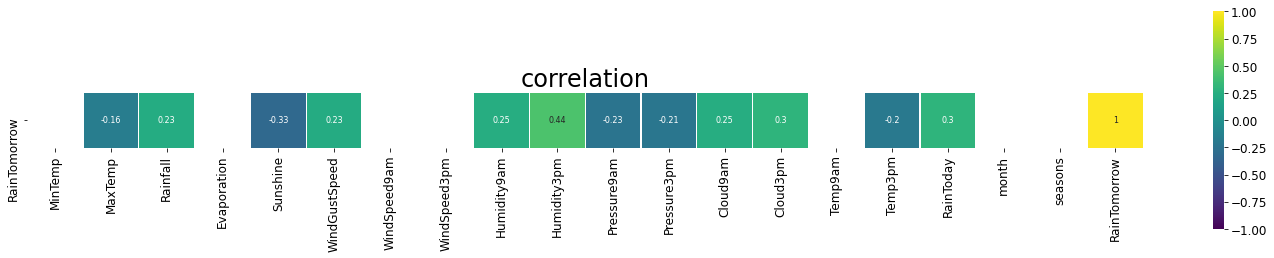

In [ ]:
corr = df.corr().tail(1)
plt.figure(figsize=(25, 4))

sns.heatmap(corr[(corr > 0.1) | (corr < -0.1)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.05,
            annot=True, annot_kws={"size": 8}, square=True)
plt.title("correlation");

Наиболее сильно коррелируют с целевым признаком следующие признаки:

In [ ]:
corr[(corr > 0.2) | (corr < -0.2)].dropna(axis=1)

Rainfall  Sunshine  ...  RainToday  RainTomorrow
RainTomorrow  0.233628 -0.325108  ...   0.302597           1.0

[1 rows x 11 columns]

Также стоит посмотреть на предсказательные способности признаков.

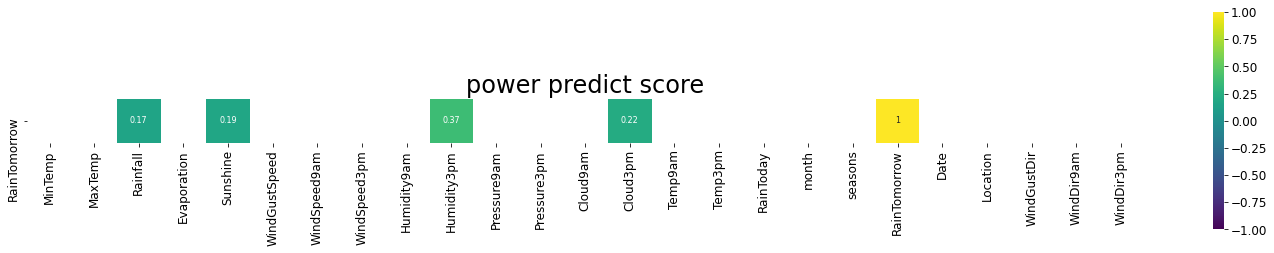

In [ ]:
pps = corr
for col in df.columns:
    score = ppscore.score(df, col, 'RainTomorrow')['ppscore']
    pps[col] = score if abs(score) > 0.1 else np.nan

plt.figure(figsize=(25, 4))
sns.heatmap(pps, cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)
plt.title("power predict score");

Наиболее сильными предсказательными способностями обладают следующие признаки:

In [ ]:
pps.dropna(axis=1)

Rainfall  Sunshine  Humidity3pm  Cloud3pm  RainTomorrow
RainTomorrow  0.169976  0.186888     0.374758  0.223175             1

Таким образом, наиболее сильно влияют на целевой признак признаки `Rainfall`, `Sunshine`, `WindGustSpeed`, `Humidity9am`, `Humidity3pm`, `Pressure9am`, `Pressure3pm`, `Cloud9am`, `Cloud3pm` и `RainToday`. 
Но только признаки  `Rainfall`,	`Sunshine`,	`Humidity3pm`	и `Cloud3pm` имеют существенную предсказательную силу.
Будем иметь это в виду и оставим в датасете все признаки, так как признаков относительно немного и среди них нет сильно неподходящих.

### 2.3 РАЗБИЕНИЕ ДАННЫХ НА ОБУЧАЮЩУЮ И ТЕСТИРУЮЩУЮ ВЫБОРКИ

Прежде чем разбивать данные на обучающую и тестирующую выборки необходимо как минимум кодировать с помощью _one-hot_ кодирования категориальные признаки и масштабировать числовые.

In [ ]:
sc = StandardScaler()
sc.fit(df[int_feat])
df[int_feat] = sc.transform(df[int_feat])

In [ ]:
df = pd.get_dummies(df, drop_first=True)
# Теперь датафрейм выглядит как-то так
df

Date   MinTemp  ...  WindDir3pm_WNW  WindDir3pm_WSW
0      2008-12-01  0.237333  ...               1               0
1      2008-12-02 -0.738836  ...               0               1
2      2008-12-03  0.155986  ...               0               1
3      2008-12-04 -0.445986  ...               0               0
4      2008-12-05  0.904382  ...               0               0
...           ...       ...  ...             ...             ...
128481 2013-10-08  0.237333  ...               1               0
128482 2013-10-09 -0.169404  ...               0               0
128483 2013-10-10 -0.413447  ...               1               0
128484 2013-10-11  0.269872  ...               0               1
128485 2013-10-12 -0.608680  ...               0               0

[125360 rows x 108 columns]

Разобьём данные на обучающую и тестирующую выборки в соотношении 75% к 25% соответственно с сохранением баланса целевой переменной (используем стратегию стратификации (равномерного распределения) классов).

Возможно, стоило бы разбить данные на обучающую и тестирующую выборки не случайным образом, а основываясь на дате, то есть следующим образом:

```python
test_size=0.25
train_inx  = round(len(X) * (1 - test_size))
X_train, X_test, y_train, y_test = X[:train_inx], X[train_inx:], y[:train_inx], y[train_inx:]
```

Другими словами, тестирующая выборка будет самой свежей по дате симулируя таким образом только что полученные данные.
Однако таким способом будет сложнее добиться равномерного распределения классов, что, на мой взгляд, несклолько важнее.


In [ ]:
X = df.drop(columns=['RainTomorrow', 'Date'])
y = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=7)
X_train

MinTemp   MaxTemp  ...  WindDir3pm_WNW  WindDir3pm_WSW
114414 -0.917801 -0.040934  ...               0               0
90520   0.676609  0.251140  ...               0               0
19241   1.115886 -0.303801  ...               0               0
114904 -0.576142 -0.610479  ...               0               0
127835  0.969460  0.528611  ...               1               0
...          ...       ...  ...             ...             ...
36047   1.522623  1.068949  ...               0               0
72922   1.571431  2.310265  ...               0               0
36686  -1.096765 -1.603533  ...               1               0
108197 -0.185674 -0.873346  ...               0               0
37479  -2.138013 -0.873346  ...               0               0

[94020 rows x 106 columns]

### 2.4 АРГУМЕНТИРОВАННЫЙ ВЫБОР МОДЕЛИ КЛАССИФИКАЦИИ

Построим и сравним следующие модели:
- LogisticRegression
- Naive Bayes
- RandomForest
- XGBoost
- LightGBM

Сразу можно отметить, что модель `Naive Bayes`, скорее всего, покажет себя хуже всех, так как признаки являются несколько зависимыми.

In [ ]:
%%time
classifier = LogisticRegression(random_state=7)
logisticRegression = create_model_and_print_metrics(classifier, X_train, X_test, y_train, y_test)

[[22877  1338]
 [ 3510  3615]]
              precision    recall  f1-score   support

       False       0.87      0.94      0.90     24215
        True       0.73      0.51      0.60      7125

    accuracy                           0.85     31340
   macro avg       0.80      0.73      0.75     31340
weighted avg       0.84      0.85      0.83     31340

CPU times: user 8.31 s, sys: 1.74 s, total: 10.1 s
Wall time: 5.52 s


In [ ]:
%%time
classifier = GaussianNB()
gaussianNB = create_model_and_print_metrics(classifier, X_train, X_test, y_train, y_test)
# Интересно, что характеристика полноты класса `True` (т.е. дождь пойдёт) 
# у наивного байесовского классификатора самая высокая среди прочих
# (возможно, стоило бы подумать над композицией алгоритмов с участием GaussianNB)

[[16653  7562]
 [ 2335  4790]]
              precision    recall  f1-score   support

       False       0.88      0.69      0.77     24215
        True       0.39      0.67      0.49      7125

    accuracy                           0.68     31340
   macro avg       0.63      0.68      0.63     31340
weighted avg       0.77      0.68      0.71     31340

CPU times: user 897 ms, sys: 112 ms, total: 1.01 s
Wall time: 1.01 s


In [ ]:
%%time
classifier = RandomForestClassifier(random_state=7)
randomForestClassifier = create_model_and_print_metrics(classifier, X_train, X_test, y_train, y_test)

[[23186  1029]
 [ 3509  3616]]
              precision    recall  f1-score   support

       False       0.87      0.96      0.91     24215
        True       0.78      0.51      0.61      7125

    accuracy                           0.86     31340
   macro avg       0.82      0.73      0.76     31340
weighted avg       0.85      0.86      0.84     31340

CPU times: user 32.9 s, sys: 255 ms, total: 33.2 s
Wall time: 32.9 s


In [ ]:
%%time
classifier = XGBClassifier(random_state=7)
xgbClassifier = create_model_and_print_metrics(classifier, X_train, X_test, y_train, y_test)

[[23111  1104]
 [ 3638  3487]]
              precision    recall  f1-score   support

       False       0.86      0.95      0.91     24215
        True       0.76      0.49      0.60      7125

    accuracy                           0.85     31340
   macro avg       0.81      0.72      0.75     31340
weighted avg       0.84      0.85      0.84     31340

CPU times: user 25.1 s, sys: 300 ms, total: 25.4 s
Wall time: 25.3 s


In [ ]:
%%time
classifier = LGBMClassifier(random_state=7)
lightGBMClassifier = create_model_and_print_metrics(classifier, X_train, X_test, y_train, y_test)

[[22939  1276]
 [ 3274  3851]]
              precision    recall  f1-score   support

       False       0.88      0.95      0.91     24215
        True       0.75      0.54      0.63      7125

    accuracy                           0.85     31340
   macro avg       0.81      0.74      0.77     31340
weighted avg       0.85      0.85      0.85     31340

CPU times: user 3.5 s, sys: 81.9 ms, total: 3.58 s
Wall time: 3.56 s


На удивление, судя по метрикам, все модели, кроме наивного байесовского классификатора, показали себя достаточно схоже.
Какая-то модель чуть лучше в одном месте, но чуть хуже в другом относительно других моделей.
Поэтому выбор итоговой модели остановился на модели `LGBMClassifier`, так как данная модель, помимо наивного байесовского классификатора, обладает наибольшей
полнотой класса `True` (т.е. дождь пойдёт).
Всё зависит от того, в какой сфере будет использоваться модель, но обычно лучше ошибиться и предсказать, что дождь пойдёт, но его не было, чем наоборот.


## Модуль С. Разработка прикладного решения.

## Подключение необходимых библиотек и сериализация выбранной модели

In [ ]:
!pip install streamlit

In [ ]:
import os
import streamlit as st
import joblib

Сериализуем модель:

In [ ]:
joblib.dump(lightGBMClassifier, 'models/lgb.pkl')

['models/lgb.pkl']

Десериализуем модель:

In [ ]:
lightGBMClassifier_new = joblib.load('models/lgb.pkl')
y_pred = lightGBMClassifier_new.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[22939  1276]
 [ 3274  3851]]
              precision    recall  f1-score   support

       False       0.88      0.95      0.91     24215
        True       0.75      0.54      0.63      7125

    accuracy                           0.85     31340
   macro avg       0.81      0.74      0.77     31340
weighted avg       0.85      0.85      0.85     31340



## Разработка дэшборда

### Страница с информацией о датасете


Код данной станицы приведён ниже:

```python
def page_description_data():
    title()

    st.write(
        '## Исходный датасет'
    )

    st.write(
        'Исходный датасет имеет множество различных метеорологический данных, например, '
        'минимальная температура, максимальная температура, давление, скорость ветра, '
        'место в котором проводились измерения, был ли сегодня дождь и многое другое.'
    )

    st.write(
        '## Обработанный датасет'
    )

    st.write(
        'Первое что бросается в глаза после проведения первичного '
        'анализа данных, в датасете имеется большое количество пропущенных '
        'значений, удалив которые, мы бы потеряли минимум половину датасета, '
        'следовательно, необходимо их заполнить.'
    )

    st.write(
        'Пропуски в данных признаках были заполнены с '
        'помощью стандартных методов заполнения пропусков в машинном обучении, '
        'а именно заполнением самым популярным вариантом, для категориальных '
        'признаков, и заполнением средним значением, для вещественных.'
    )

    st.write(
        'После заполнения пропущенных значений необходимо обработать признаки. '
        'Признак агрегат с датой `Date` был преобразован к типу `Datetime` и '
        'разделён на такие признаки как, год, месяц, день и время года.'
    )

    st.write(
        'Наконец, осталось масштабировать вещественные признаки и '
        'применить one-hot кодирование к категориальным и можно приступать '
        'к построению моделей.'
    )
```

### Страница с информацией о построенных моделях

Код данной станицы приведён ниже:

```python
def page_description_models():
    title()

    st.write('## Построение моделей')

    st.markdown(
        '''
        В качестве моделей для построения были выбраны следующие 
        модели, как наиболее продвинутые:
        
        - _LogisticRegression_
        - _Naive Bayes_
        - _RandomForest_
        - _XGBoost_
        - _LightGBM_
        
        Данные модели и их композиции часто дают лучшие результаты для задач классификации.
        '''
    )

    st.write(
        'Проведя глубокий анализ выбранных обученных моделей, '
        'была выбрана модель LGBMClassifier из библиотеки lightgbm в качестве основной.'
    )

```

### Страница с возможностью использовать модель

Чтобы обработать данные, которые пользователи будут загружать, необходимо загрузить часть датасета. Сформируем его:

In [201]:
data_for_pretreatment = pd.read_csv('data/weather.csv')

data_for_pretreatment.dropna(inplace=True)

from random import randint

numbers = []
for i in range(5000):
  number = randint(0, len(data_for_pretreatment))
  if number not in numbers:
    numbers.append(number)

data_for_pretreatment = data_for_pretreatment.iloc[numbers]
data_for_pretreatment

Date       Location  MinTemp  ...  Temp3pm  RainToday  RainTomorrow
21775   2010-10-19  NorfolkIsland     13.6  ...     19.6         No           Yes
32434   2014-07-06         Sydney      8.2  ...     16.2         No            No
67538   2009-06-04      Melbourne     12.3  ...     16.5        Yes            No
33103   2016-05-05         Sydney     13.5  ...     21.3         No            No
40103   2010-07-20    Williamtown      5.8  ...     14.9        Yes           Yes
...            ...            ...      ...  ...      ...        ...           ...
62046   2011-06-14           Sale      5.5  ...     13.5         No            No
86809   2016-05-31       Brisbane     11.3  ...     21.8         No            No
104865  2015-07-30      Nuriootpa      4.0  ...     13.8         No            No
68988   2013-08-21      Melbourne      6.8  ...     13.3         No            No
37326   2011-03-09     WaggaWagga     15.1  ...     22.1         No           Yes

[4734 rows x 23 columns]

In [202]:
data = pd.read_csv('data/weather.csv')
data[cat_feat[0]].nunique()

43

In [203]:
data_for_pretreatment[cat_feat[0]].nunique()

23

In [204]:
feat = frozenset(data[cat_feat[0]].unique()) - frozenset(data_for_pretreatment[cat_feat[0]].unique())
feat = list(feat)
len(feat)

20

In [205]:

for num in range(len(feat)):
  rows = data[data[cat_feat[0]] == list(feat)[num]].head(2)
  data_for_pretreatment = data_for_pretreatment.append(rows, ignore_index=True)

data_for_pretreatment

Date       Location  MinTemp  ...  Temp3pm  RainToday  RainTomorrow
0     2010-10-19  NorfolkIsland     13.6  ...     19.6         No           Yes
1     2014-07-06         Sydney      8.2  ...     16.2         No            No
2     2009-06-04      Melbourne     12.3  ...     16.5        Yes            No
3     2016-05-05         Sydney     13.5  ...     21.3         No            No
4     2010-07-20    Williamtown      5.8  ...     14.9        Yes           Yes
...          ...            ...      ...  ...      ...        ...           ...
4769  2008-12-02     Wollongong      NaN  ...      NaN        NaN           NaN
4770  2009-01-01     SalmonGums     14.8  ...     30.1         No            No
4771  2009-01-02     SalmonGums     14.7  ...     35.7         No            No
4772  2009-01-01     PearceRAAF     18.8  ...     35.6         No            No
4773  2009-01-02     PearceRAAF     22.0  ...     36.0         No            No

[4774 rows x 23 columns]

In [206]:
data_for_pretreatment[cat_feat[0]].nunique()

43

In [210]:
for num in range(len(cat_feat)):
  print(data[cat_feat[num]].nunique() == data_for_pretreatment[cat_feat[num]].nunique())

True
True
True
True


In [207]:
data_for_pretreatment.drop(columns=['RainTomorrow']).to_csv('data/data_for_pretreatment.csv', index=False)

Код данной станицы приведён ниже:

```python
def page_using_model():
    title()

    st.write('## Использование модели')

    st.write(
        'Ниже вы можете задать параметры в файле (сколько строк в файле будет, столько и будет предсказаний) '
        'и получить прогноз на наличие дождя:'
    )

    file = st.file_uploader(label='Загрузите данные для предсказания', type=['csv'], accept_multiple_files=False)
    if file is not None:
        df = pd.read_csv(file)
        st.write('### Исходные данные')
        st.write(df)
        st.write('Размерность датафрейма {}'.format(df.shape))
        st.write('### Данные после обработки')
        df = data_preprocessing(df)
        st.write(df)
        st.write('Размерность датафрейма {}'.format(df.shape))
        model_prediction(df)


def data_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    if 'RainTomorrow' in df.columns:
        df.drop(columns='RainTomorrow', inplace=True)

    # Объединение с исходными данными для дальнейшей обработки входных данных
    df_len = len(df)
    df = df.append(load_data_for_pretreatment(), ignore_index=True)

    # Обработка данных
    df['Date'] = pd.to_datetime(df['Date'])
    df['month'] = df['Date'].dt.month
    df['seasons'] = 4
    df.loc[np.logical_and(np.array(3 <= df['month']), np.array(df['month'] <= 5)), 'seasons'] = 1
    df.loc[np.logical_and(np.array(6 <= df['month']), np.array(df['month'] <= 8)), 'seasons'] = 2
    df.loc[np.logical_and(np.array(9 <= df['month']), np.array(df['month'] <= 11)), 'seasons'] = 3

    df.drop(df[df['RainTomorrow'].isna()].index, axis=0, inplace=True)

    int_feat = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
                'Temp9am', 'Temp3pm', 'month', 'seasons']

    bool_feat = ['RainToday', 'RainTomorrow']

    df[int_feat] = df[int_feat].fillna(df[int_feat].mean())

    df['Location'] = df['Location'].fillna(df['Location'].mode()[0])
    df['WindGustDir'] = df['WindGustDir'].fillna(df['WindGustDir'].mode()[0])
    df['WindDir9am'] = df['WindDir9am'].fillna(df['WindDir9am'].mode()[0])
    df['WindDir3pm'] = df['WindDir3pm'].fillna(df['WindDir3pm'].mode()[0])

    df['RainToday'] = df['RainToday'].fillna(df['RainToday'].mode()[0])

    df[bool_feat] = df[bool_feat].replace(['No'], False)
    df[bool_feat] = df[bool_feat].replace(['Yes'], True)

    sc = StandardScaler()
    sc.fit(df[int_feat])
    df[int_feat] = sc.transform(df[int_feat])
    df = pd.get_dummies(df, drop_first=True)
    df.drop(columns=['Date'], inplace=True)
    return df


def model_prediction(X: pd.DataFrame):
    st.write('### Предсказанные значения')
    model = load_model_lightgbm()
    pred = model.predict(X)
    del X
    pred = pd.DataFrame(pred, columns=['RainTomorrow'])
    st.write(pred)



def load_model_lightgbm():
    model = joblib.load('models/lgb.pkl')
    return model


@st.cache
def load_data_for_pretreatment():
    df = pd.read_csv(ABSOLUTE_PATH + '/data/data_for_pretreatment.csv')
    return df
```